In [35]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import pandas as pd
import numpy as np

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, cross_validate
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif



# **Machine Learning - Lab 1: Music Genre Classificartion**

In this lab we'll play around with different classic ML approach to try to solve a music classification task. This work aims to be an overview of relevant practices around the discussed methods and will illustrate and discuss how the  differnt tested approaches perform for our specific task.

But first...we need data! The following cells load the data from a Google Drive location


In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
genreAll = pd.read_csv("/content/drive/MyDrive/ML/Lab1/data/GenreAll.csv")
for col in genreAll.columns:
    genreAll.rename(columns={col:col.strip()}, inplace = True)
feat_30 = pd.read_csv("/content/drive/MyDrive/ML/Lab1/data/features_30_sec.csv")
feat_3 = pd.read_csv("/content/drive/MyDrive/ML/Lab1/data/features_3_sec.csv")


## **Data Overview**

In order to know how to approach the problem, it's a good practive to visualize the data. First we'll make sure how balanced are our datasets, and after that we'll try to reduce the feature space and plot our data. This can give us an overview about potential limitations of the methods we want to use and appropiate parameter selection.
Since we've already noticed that the data is not normalized, whenever we find a non-string column we normalize it so that all the features are in a common value range

In [38]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

#scaler = MinMaxScaler()
scaler = preprocessing.StandardScaler()


nrows, ncols = genreAll.shape
print("GenreAll dataset:")
print(f"Nbr of observations: {nrows-1}\nNbr of features: {ncols-2}")
print(f"Nbr of classes: {pd.unique(genreAll.genre).size}")

for col in genreAll.columns:
    if genreAll[col].isna().sum()!=0: print(f"{genreAll[col].isna().sum()} NaN found in col {col}")
    if isinstance(genreAll[col][0], str):
        print(f'  Textual column : {col} (values: {genreAll[col].unique()})')
    else:
        genreAll[col] = scaler.fit_transform(genreAll[[col]])

genreAll.rename(columns={'genre':'label'}, inplace=True) #so that all the datasets have the same solumn name for the label

nrows, ncols = feat_30.shape
print("--------------------------------------------")
print("feature30 dataset:")
print(f"Nbr of observations: {nrows-1}\nNbr of features: {ncols-3}")
print(f"Nbr of classes: {pd.unique(feat_30.label).size}")

for col in feat_30.columns[1:]:
    if isinstance(feat_30[col][0], str): print(f'  Textual column : {col} (values: {feat_30[col].unique()})')
    else:
        feat_30[col] = scaler.fit_transform(feat_30[[col]])

        #feat_30[col] = (feat_30[col]-feat_30[col].min())/(feat_30[col].max()-feat_30[col].min())


nrows, ncols = feat_3.shape
print("--------------------------------------------")
print("feature3 dataset:")
print(f"Nbr of observations: {nrows-1}\nNbr of features: {ncols-3}")
print(f"Nbr of classes: {pd.unique(feat_3.label).size}")
for col in feat_3.columns[1:]:
    if isinstance(feat_3[col][0], str): print(f'  Textual column : {col} (values: {feat_3[col].unique()})')
    else:
        feat_3[col] = scaler.fit_transform(feat_3[[col]])

        #feat_3[col] = (feat_3[col]-feat_3[col].min())/(feat_3[col].max()-feat_3[col].min())



GenreAll dataset:
Nbr of observations: 992
Nbr of features: 239
Nbr of classes: 10
  Textual column : highlevel_speech_music_value (values: ['speech' 'music'])
  Textual column : highlevel_voice_instrumental_value (values: ['instrumental' 'voice'])
  Textual column : tonal_key_mode_value (values: ['major' 'minor'])
  Textual column : genre (values: ['blu' 'cla' 'cou' 'dis' 'hip' 'jaz' 'met' 'pop' 'reg' 'roc'])
--------------------------------------------
feature30 dataset:
Nbr of observations: 999
Nbr of features: 57
Nbr of classes: 10
  Textual column : label (values: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock'])
--------------------------------------------
feature3 dataset:
Nbr of observations: 9989
Nbr of features: 57
Nbr of classes: 10
  Textual column : label (values: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock'])


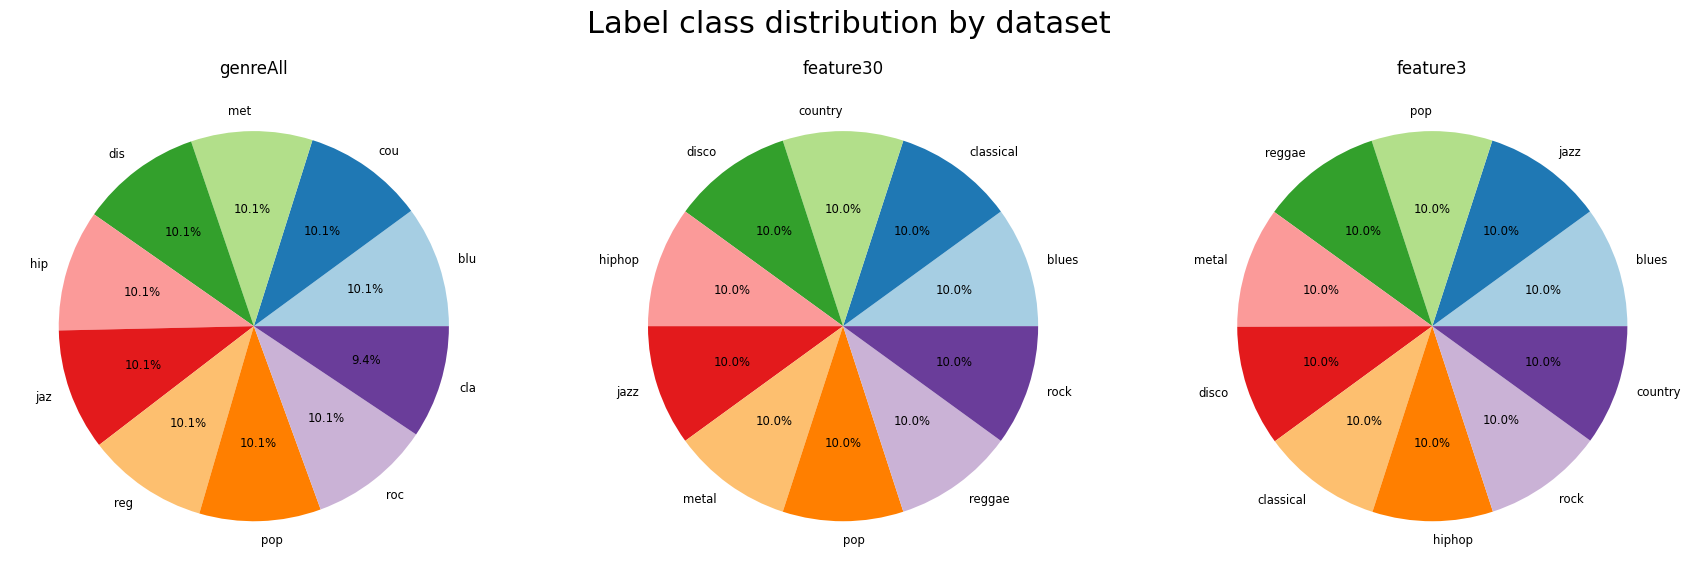

In [39]:
import matplotlib.pyplot as plt

# Example: replace these with your actual DataFrames
datasets = {
    'genreAll': genreAll,
    'feature30': feat_30,
    'feature3': feat_3
    }

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # smaller width makes pies larger

colors = plt.cm.Paired.colors

for ax, (name, df) in zip(axes, datasets.items()):
    count_df = df['label'].value_counts().reset_index()
    count_df.columns = ['values', 'counts']

    ax.pie(count_df['counts'], labels=count_df['values'], autopct='%.1f%%',
           textprops={'size': 'smaller'}, radius=1,
           colors=colors[:len(count_df)])
    ax.set_title(f'{name}')

fig.suptitle('Label class distribution by dataset', fontsize=22)

plt.tight_layout(pad=2.0)
plt.show()


In [40]:

#replace string-valued rows with integers
genre_dict = {'blu':0, 'cla':1, 'cou':2, 'dis':3, 'hip':4, 'jaz':5, 'met':6, 'pop':7, 'reg':8,'roc':9}
highlevel_speech_music_value_dict = {'music':0, 'speech':1}
highlevel_voice_instrumental_value_dict = {'instrumental':0, 'voice':1}
tonal_key_mode_value_dict = {'minor':0, 'major':1}

genreAll['highlevel_speech_music_value'] = genreAll['highlevel_speech_music_value'].replace(highlevel_speech_music_value_dict)
genreAll['highlevel_voice_instrumental_value'] = genreAll['highlevel_voice_instrumental_value'].replace(highlevel_voice_instrumental_value_dict)
genreAll['tonal_key_mode_value'] = genreAll['tonal_key_mode_value'].replace(tonal_key_mode_value_dict)
genreAll['label'] = genreAll['label'].replace(genre_dict)

feat_label_dict = {'blues':0, 'classical':1, 'country':2, 'disco':3, 'hiphop':4, 'jazz':5, 'metal':6, 'pop':7, 'reggae':8,'rock':9}
feat_30['label'] = feat_30['label'].replace(feat_label_dict)

feat_label_dict = {'blues':0, 'classical':1, 'country':2, 'disco':3, 'hiphop':4, 'jazz':5, 'metal':6, 'pop':7, 'reggae':8,'rock':9}
feat_3['label'] = feat_3['label'].replace(feat_label_dict)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [96 98] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


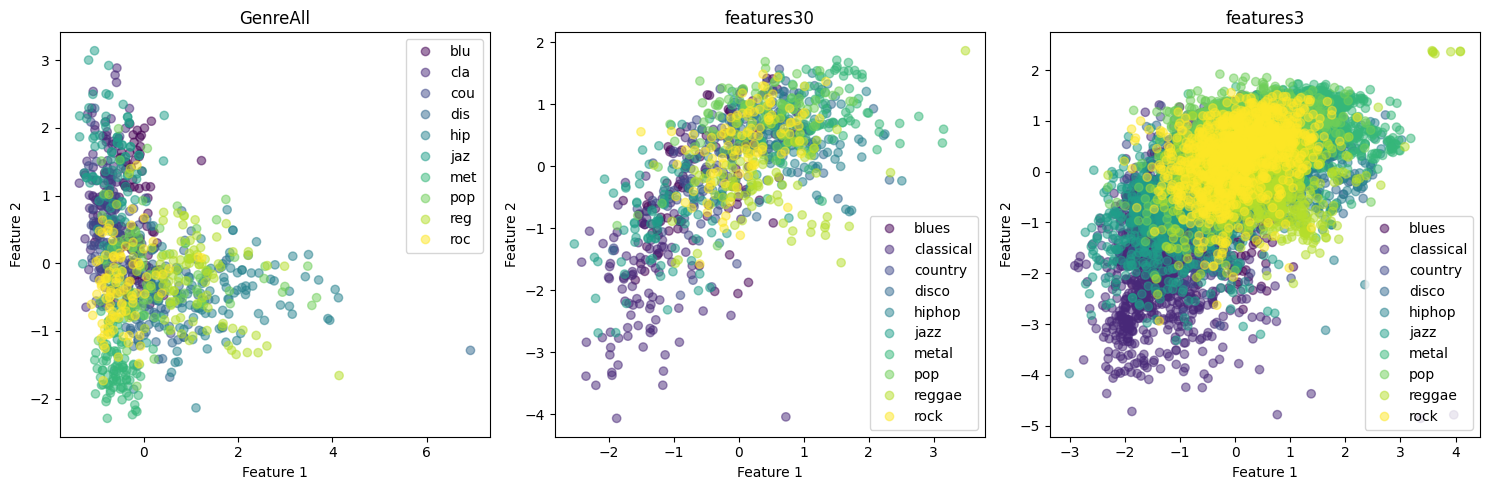

In [41]:
# Invert tag dictionary (int -> string)
inv_genre_dic = {v: k for k, v in genre_dict.items()}
# Invert tag dictionary (int -> string)
inv_feat_label_dict = {v: k for k, v in feat_label_dict.items()}

featSelector = SelectKBest(f_classif, k=2)
D2_allGenre = featSelector.fit_transform(genreAll[genreAll.columns[2:-1]],genreAll[genreAll.columns[-1]])
D2_allGenre = np.concatenate((D2_allGenre, genreAll[genreAll.columns[-1]].values.reshape(-1, 1)), axis=1)

D2_feat30 = featSelector.fit_transform(feat_30[feat_30.columns[2:-1]],feat_30[feat_30.columns[-1]])
D2_feat30 = np.concatenate((D2_feat30, feat_30[feat_30.columns[-1]].values.reshape(-1, 1)), axis=1)

D2_feat3 = featSelector.fit_transform(feat_3[feat_3.columns[2:-1]],feat_3[feat_3.columns[-1]])
D2_feat3 = np.concatenate((D2_feat3, feat_3[feat_3.columns[-1]].values.reshape(-1, 1)), axis=1)

plt.figure(figsize=(15, 5))

# Define the labels for each dataset
labels_allGenre = [inv_genre_dic[i] for i in genreAll['label'].unique()]
labels_feat30 = [inv_feat_label_dict[i] for i in feat_30['label'].unique()]
labels_feat3 = [inv_feat_label_dict[i] for i in feat_3['label'].unique()]

plt.subplot(1, 3, 1)
scatter1 = plt.scatter(D2_allGenre[:, 0], D2_allGenre[:, 1], c=D2_allGenre[:, -1], cmap='viridis', alpha=0.5)
plt.title('GenreAll')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(handles=scatter1.legend_elements()[0], labels=labels_allGenre)

plt.subplot(1, 3, 2)
scatter2 = plt.scatter(D2_feat30[:, 0], D2_feat30[:, 1], c=D2_feat30[:, -1], cmap='viridis', alpha=0.5)
plt.title('features30')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(handles=scatter2.legend_elements()[0], labels=labels_feat30)

plt.subplot(1, 3, 3)
scatter3 = plt.scatter(D2_feat3[:, 0], D2_feat3[:, 1], c=D2_feat3[:, -1], cmap='viridis', alpha=0.5)
plt.title('features3')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(handles=scatter3.legend_elements()[0], labels=labels_feat3)


plt.tight_layout()
plt.show()

As we can see from the pie charts, the dostrobution of the data is balanced, which will allow us to use equal-weigthning strategies and average across single-class accuracy without worring about a too-good classified class masking a too-bad-classified class results.

From the scatterplot, it's difficult to derive conclusions. We can see the effect of the normalization, and also predict that classical music will most likelly be the easiest to classify, since it's already a bit apart from the rest of the datapoints even when reducing the space to 2 dimensions, specially int he features dataset.

## Feature Selection

We have a lot of features. As a rule od thumb, we want to have ten times more datapoints than # of features, which means that at most we would like to have around 100 features for the GenreAll dataset. For the other two datasets, we could try to work with what we have, but we'll also half the feature space so that the computations are not that exhaustive.


It's difficult to know the ideal dimensionality reduction, therefor we'll pick a value that meets the rule of thumb just mentioned, and later we can play around with this number. From the

In [42]:
featSelector = SelectKBest(f_classif, k=60)
reduced_allGenre = featSelector.fit_transform(genreAll[genreAll.columns[:-1]],genreAll[genreAll.columns[-1]])
reduced_allGenre = np.concatenate((reduced_allGenre, genreAll[genreAll.columns[-1]].values.reshape(-1, 1)), axis=1)

featSelector = SelectKBest(f_classif, k=30)
reduced_feat30 = featSelector.fit_transform(feat_30[feat_30.columns[2:-1]],feat_30[feat_30.columns[-1]])
reduced_feat30= np.concatenate((feat_30[feat_30.columns[0]].values.reshape(-1, 1),reduced_feat30, feat_30[feat_30.columns[-1]].values.reshape(-1, 1)), axis=1)

featSelector = SelectKBest(f_classif, k=30)
reduced_feat3 = featSelector.fit_transform(feat_3[feat_3.columns[2:-1]],feat_3[feat_3.columns[-1]])
reduced_feat3= np.concatenate((feat_3[feat_3.columns[0]].values.reshape(-1, 1),reduced_feat3, feat_3[feat_3.columns[-1]].values.reshape(-1, 1)), axis=1)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 98 100] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [45]:
reduced_feat3

array([['blues.00000.0.wav', -0.48780784150376216, 0.6405204747329124,
        ..., -0.5157905796353937, 0.1686471185149412, 0],
       ['blues.00000.1.wav', -0.4031418707497276, 0.13183473398262677,
        ..., -0.6957513982913626, -0.32703137174835134, 0],
       ['blues.00000.2.wav', -0.3616942783460661, 0.7644908973613505,
        ..., 0.2952393192529959, 0.428052789617694, 0],
       ...,
       ['rock.00099.7.wav', -0.3543304443961362, 0.4299742602514245, ...,
        -0.8347913842730967, 0.294908460061651, 9],
       ['rock.00099.8.wav', 0.08836110055323006, -0.0063013290071570905,
        ..., -0.18409727508584334, -0.20518147729222716, 9],
       ['rock.00099.9.wav', -0.11321001698705847, 0.1953632354098931,
        ..., -0.47730147820333846, -1.3034295892998156, 9]], dtype=object)

## Train-test splits

Now we are ready to split the data in train and test splits. We'll use an 80% of the data for trainning and keep a 20% as test. After that, we'll make sure that the train and test splits are balanced, and we'll be ready to go.

In [49]:
from sklearn.model_selection import train_test_split
data = {
    'genreAll':{'X_train':[],'y_train':[],'X_test':[],'y_test':[]},
    'feat_30':{'X_train':[],'y_train':[],'X_test':[],'y_test':[]},
    'feat_3':{'X_train':[],'y_train':[],'X_test':[],'y_test':[]},
}


data['genreAll']['X_train'], data['genreAll']['X_test'], data['genreAll']['y_train'], data['genreAll']['y_test'] = train_test_split(reduced_allGenre[:,:-1], reduced_allGenre[:,-1], test_size=0.20)
data['feat_30']['X_train'], data['feat_30']['X_test'], data['feat_30']['y_train'], data['feat_30']['y_test'] = train_test_split(reduced_feat30[:,0:-1], reduced_feat30[:,-1], test_size=0.20)


In [55]:
from sklearn.model_selection import train_test_split
data = {
    'genreAll':{'X_train':[],'y_train':[],'X_test':[],'y_test':[]},
    'feat_30':{'X_train':[],'y_train':[],'X_test':[],'y_test':[]},
    'feat_3':{'X_train':[],'y_train':[],'X_test':[],'y_test':[]},
}


data['genreAll']['X_train'], data['genreAll']['X_test'], data['genreAll']['y_train'], data['genreAll']['y_test'] = train_test_split(reduced_allGenre[:,:-1], reduced_allGenre[:,-1], test_size=0.20)
data['feat_30']['X_train'], data['feat_30']['X_test'], data['feat_30']['y_train'], data['feat_30']['y_test'] = train_test_split(reduced_feat30[:,0:-1], reduced_feat30[:,-1], test_size=0.20)

# Note that features_3.csv contains multiple fragments of the same song
# Fragments of the same song shouldn't be at the same time in the train and test splits
train_filenames = np.unique(data['feat_30']['X_train'][:,0]) # Access filename by index (assuming filename is the first column)
test_filenames = np.unique(data['feat_30']['X_test'][:,0]) # Access filename by index

#now we can get rid of them in the feat30 data
data['feat_30']['X_train'] = data['feat_30']['X_train'][:, 1:] # Exclude filename
data['feat_30']['X_test'] = data['feat_30']['X_test'][:, 1:] # Exclude filename



Note that in the feature_3 dataset there are multiple fragment songs that come from the same original track. Using fragments from the same track both in the trainning stage and the testing stage would be to spoil the results, therefore we need to make sure that fragments from the same song are not part of the train and test splitst the same time.

In [58]:
# Train-test split for feat_3 dataset, ensuring fragments from the same song are in the same split
# reduced_feat3 contains [filename, feature1, feature2, ..., feature_k, label]

# Get unique original filenames from the reduced_feat3 array
# Assuming the original filename is part of the first column (filename) and formatted like 'blues.00000.0.wav'
# We need to extract the part before the last two dots (e.g., 'blues.00000')
original_filenames = np.array([f.rsplit('.', 2)[0] for f in reduced_feat3[:, 0]])
unique_original_filenames = np.unique(original_filenames)

# Split the unique original filenames into train and test sets
train_original_filenames, test_original_filenames = train_test_split(unique_original_filenames, test_size=0.20, random_state=42) # Added random_state for reproducibility

# Create boolean masks to select rows based on original filenames
train_mask = np.isin(original_filenames, train_original_filenames)
test_mask = np.isin(original_filenames, test_original_filenames)

# Apply masks to split the reduced_feat3 array
train_data = reduced_feat3[train_mask]
test_data = reduced_feat3[test_mask]

# Separate features (X) and labels (y) for train and test sets
# Assuming filename is the first column (index 0) and label is the last column (index -1)
data['feat_3']['X_train'] = train_data[:, 1:-1] # Exclude filename and label
data['feat_3']['y_train'] = train_data[:, -1]  # Only label
data['feat_3']['X_test'] = test_data[:, 1:-1]   # Exclude filename and label
data['feat_3']['y_test'] = test_data[:, -1]    # Only label

# Convert labels to appropriate data type if necessary (e.g., int)
data['feat_3']['y_train'] = data['feat_3']['y_train'].astype(int)
data['feat_3']['y_test'] = data['feat_3']['y_test'].astype(int)

print(f"feat_3 train set shape: {data['feat_3']['X_train'].shape}, labels shape: {data['feat_3']['y_train'].shape}")
print(f"feat_3 test set shape: {data['feat_3']['X_test'].shape}, labels shape: {data['feat_3']['y_test'].shape}")

feat_3 train set shape: (7993, 30), labels shape: (7993,)
feat_3 test set shape: (1997, 30), labels shape: (1997,)


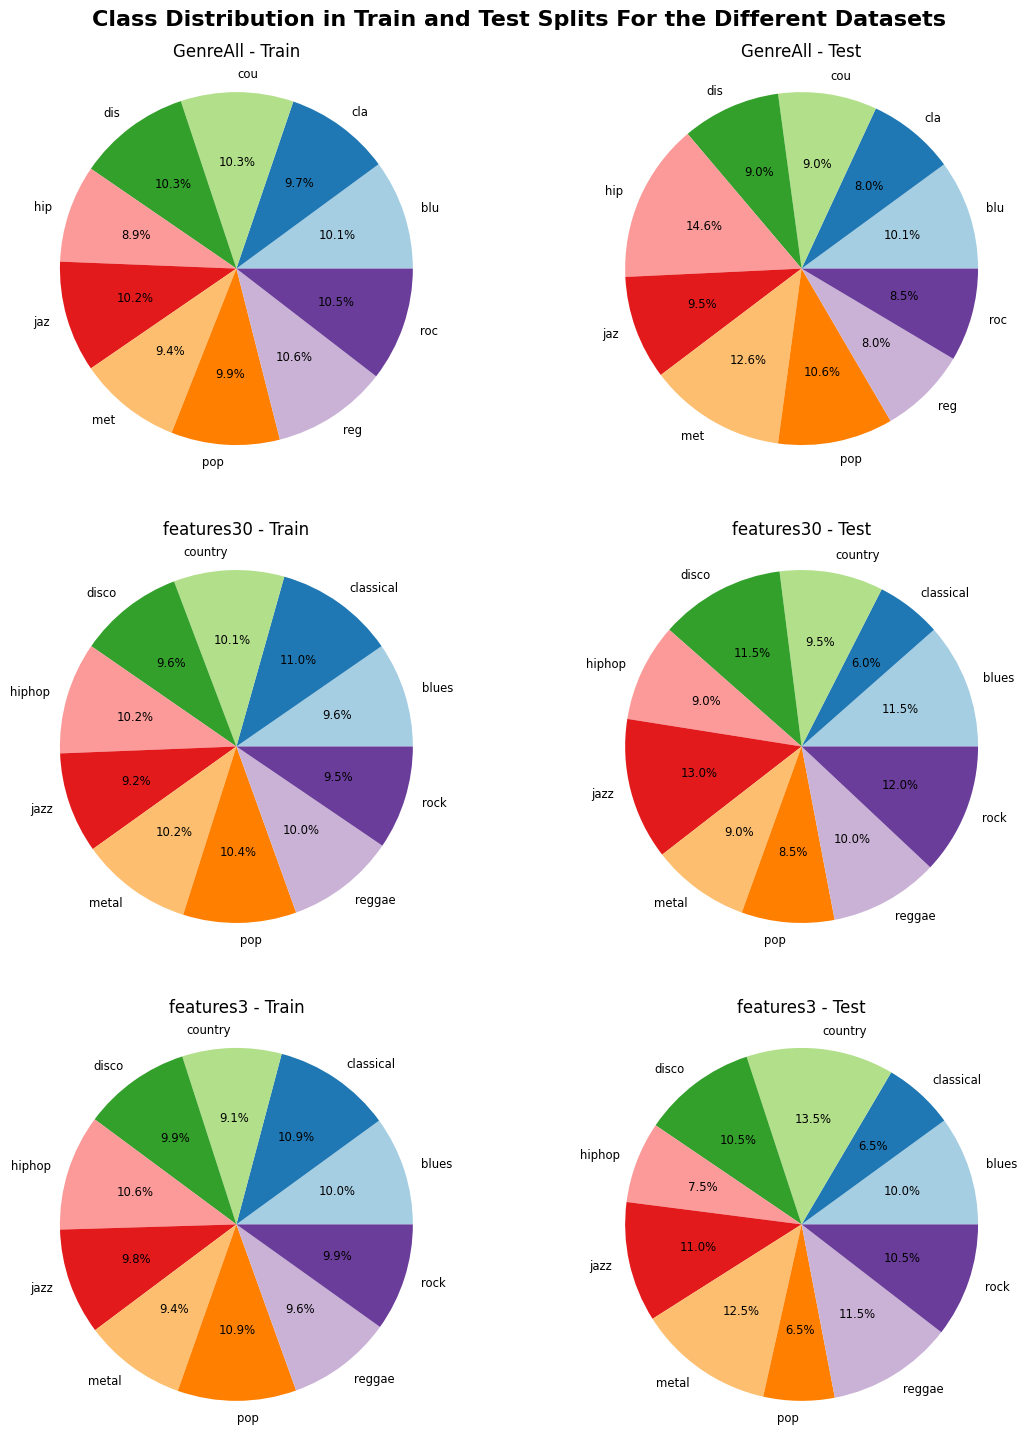

In [64]:
import matplotlib.pyplot as plt

# Invert tag dictionary (int -> string)
inv_genre_dic = {v: k for k, v in genre_dict.items()}
# Invert tag dictionary (int -> string)
inv_feat_label_dict = {v: k for k, v in feat_label_dict.items()}


# Count occurrences from np.array
unique_train, genreAll_train_counts = np.unique(data['genreAll']['y_train'], return_counts=True)
unique_test, genreAll_test_counts = np.unique(data['genreAll']['y_test'], return_counts=True)
# Convert to label names using the inverted map
genreAll_train_labels = [inv_genre_dic[int(i)] for i in unique_train]
genreAll_test_labels = [inv_genre_dic[int(i)] for i in unique_test]

# Count occurrences from numpy arrays
unique_feat30_train, feat30_train_counts = np.unique(data['feat_30']['y_train'], return_counts=True)
unique_feat30_test, feat30_test_counts = np.unique(data['feat_30']['y_test'], return_counts=True)
# Convert to label names using the inverted map
feat30_train_labels = [inv_feat_label_dict[int(i)] for i in unique_feat30_train]
feat30_test_labels = [inv_feat_label_dict[int(i)] for i in unique_feat30_test]

# Count occurrences from numpy arrays
unique_feat3_train, feat3_train_counts = np.unique(data['feat_3']['y_train'], return_counts=True)
unique_feat3_test, feat3_test_counts = np.unique(data['feat_3']['y_test'], return_counts=True)
# Convert to label names using the inverted map
feat3_train_labels = [inv_feat_label_dict[int(i)] for i in unique_feat3_train]
feat3_test_labels = [inv_feat_label_dict[int(i)] for i in unique_feat3_test]


datasets = [
    ("GenreAll", genreAll_train_counts, genreAll_test_counts, genreAll_train_labels, genreAll_test_labels),
    ("features30", feat30_train_counts, feat30_test_counts, feat30_train_labels, feat30_test_labels),
    ("features3", feat3_train_counts, feat3_test_counts, feat3_train_labels, feat3_test_labels)
]

colors = plt.cm.Paired.colors

fig, axes = plt.subplots(3, 2, figsize=(12, 15))  # 3 rows × 2 columns

for i, (name, train_counts, test_counts, train_labels, test_labels) in enumerate(datasets):
    # --- Train pie (left column) ---
    axes[i, 0].pie(
        train_counts,
        autopct='%1.1f%%',
        labels=train_labels,
        colors=colors[:len(train_labels)],
        radius=1.2,
        textprops={'size': 'smaller'}
    )
    axes[i, 0].set_title(f'{name} - Train',pad=20)

    # --- Test pie (right column) ---
    axes[i, 1].pie(
        test_counts,
        autopct='%1.1f%%',
        labels=test_labels,
        colors=colors[:len(test_labels)],
        radius=1.2,
        textprops={'size': 'smaller'}
    )
    axes[i, 1].set_title(f'{name} - Test',pad=20)

# Global title and layout tweaks
fig.suptitle('Class Distribution in Train and Test Splits For the Different Datasets', fontsize=16, fontweight='bold')
plt.tight_layout(pad=4.0)
plt.subplots_adjust(hspace=0.3, top=0.93)
plt.show()

## **Modelling**

### Logistic Regression

Lets first start with the simplest method, a logistic regresion, and see how it performs in a confussion matrix

0.7839195979899497


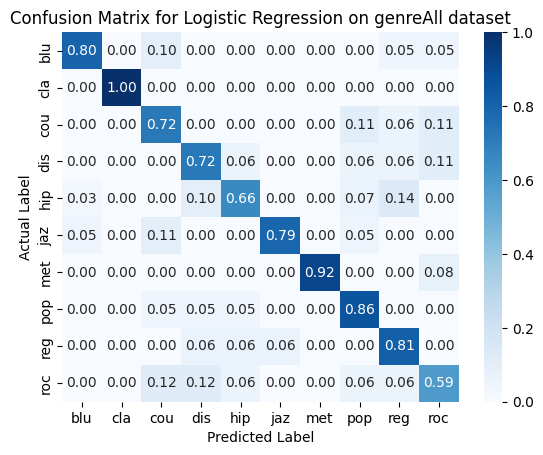

0.65


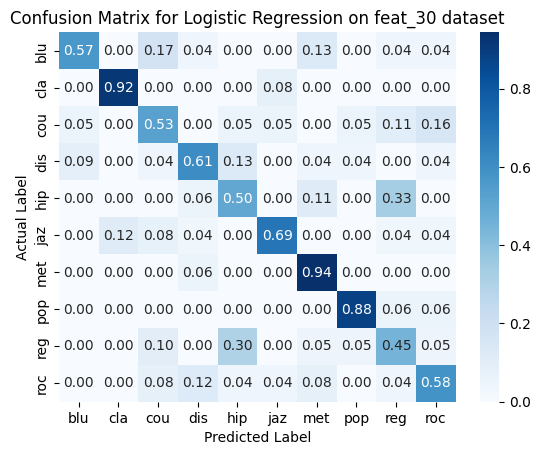

0.5968953430145217


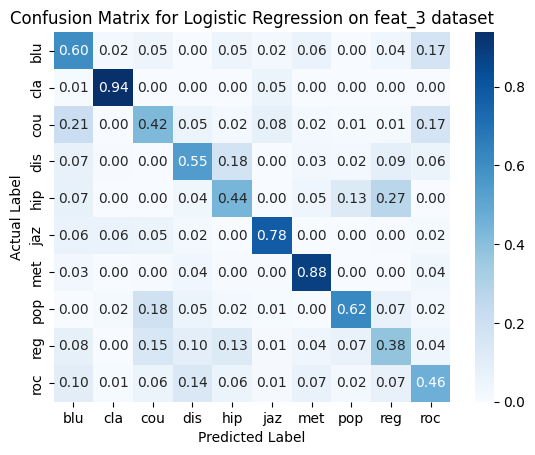

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

for dataset_name in data.keys():
    X_train = data[dataset_name]['X_train']
    y_train = data[dataset_name]['y_train'].astype(int) # Convert to integer type
    X_test = data[dataset_name]['X_test']
    y_test = data[dataset_name]['y_test'].astype(int)   # Convert to integer type

    clf = LogisticRegression(random_state=0, max_iter=500).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print("Avg Accuracy:",score)
    label_names = [i for i in genre_dict.keys()]
    singleClass_cm = multilabel_confusion_matrix(y_test, y_pred,
                                labels=genreAll.label.unique()) #tn, fn, fp, tp

    cm = confusion_matrix(y_test, y_pred,
                                labels=genreAll.label.unique(), normalize='true') #tn, fn, fp, tp
    df_cfm = pd.DataFrame(cm, index=label_names, columns=label_names)
    cfm_plot = sn.heatmap(df_cfm,annot=df_cfm,fmt=".2f",cmap="Blues")
    plt.title(f'Confusion Matrix for Logistic Regression on {dataset_name} dataset')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

## k-Nearest Neigbours

We will now try with the k-nn method, and find which k is the one that leads to best validation accuracy. We'll store the best k value for each dataset, and also try with different distance metrics.

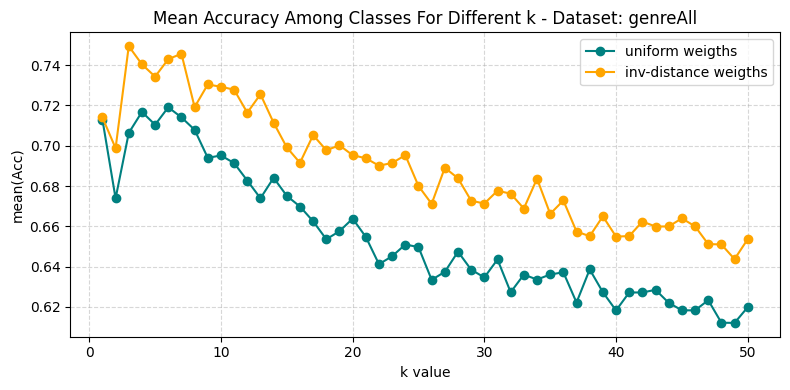

Best AccScore for uniformly weigthed distances: 0.7191 ± 0.0223 (k = 6)
Best AccScore for inv-dist weigthed distances: 0.7495 ± 0.0506 (k = 3)


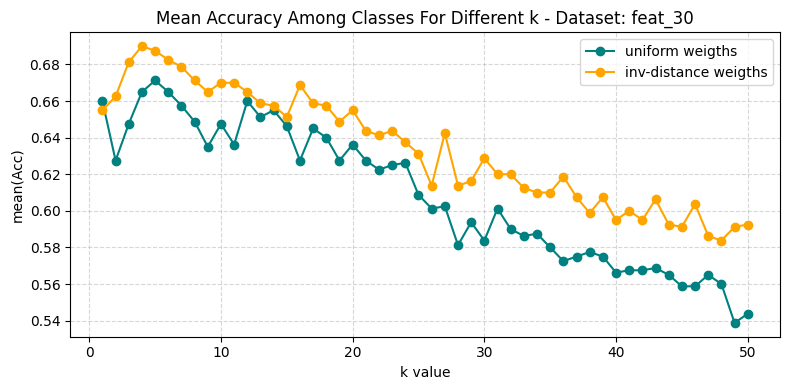

Best AccScore for uniformly weigthed distances: 0.6713 ± 0.0437 (k = 5)
Best AccScore for inv-dist weigthed distances: 0.6900 ± 0.0458 (k = 4)


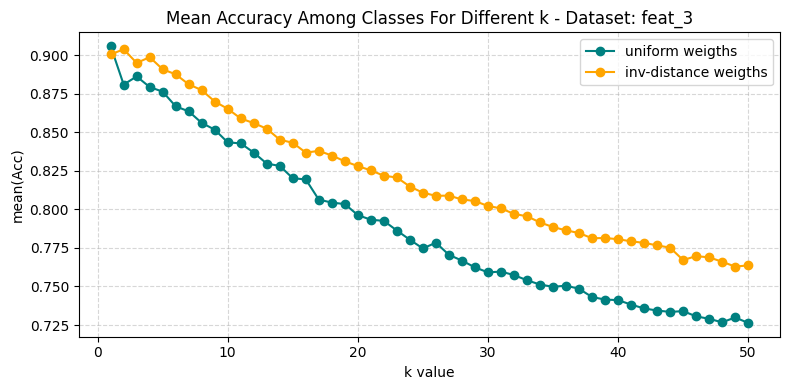

Best AccScore for uniformly weigthed distances: 0.9059 ± 0.0080 (k = 1)
Best AccScore for inv-dist weigthed distances: 0.9039 ± 0.0073 (k = 2)


In [69]:
from sklearn.neighbors import KNeighborsClassifier

kf = KFold(n_splits=10, shuffle=True)


for dataset in data.keys():
    avg_acc_kn = []
    std_acc_kn = []
    avg_acc_kn_dist = []
    std_acc_kn_dist = []
    X_train = data[dataset]['X_train']
    y_train = data[dataset]['y_train'].astype(int)
    X_test = data[dataset]['X_test']
    y_test = data[dataset]['y_test'].astype(int)
    for k in range(1,51,1):
    #uniform distance
        neigh = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(neigh, X_train,y_train, cv=kf)
        avg_acc_kn.append(scores.mean())
        std_acc_kn.append(scores.std())
    #inv-distnace
        neigh = KNeighborsClassifier(n_neighbors=k, weights='distance') #weight points by the inverse of their distance
        scores = cross_val_score(neigh, X_train,y_train, cv=kf)
        avg_acc_kn_dist.append(scores.mean())
        std_acc_kn_dist.append(scores.std())

    plt.figure(figsize=(8, 4))
    plt.plot(range(1,51,1),avg_acc_kn,'o-', color='teal', label='uniform weigths')
    plt.plot(range(1,51,1),avg_acc_kn_dist,'o-', color='orange', label='inv-distance weigths')
    plt.title(f"Mean Accuracy Among Classes For Different k - Dataset: {dataset}")
    plt.xlabel("k value")
    plt.ylabel("mean(Acc)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
    data[dataset]['best_k'] = np.argmax(avg_acc_kn)+1 if max(avg_acc_kn)>max(avg_acc_kn_dist) else np.argmax(avg_acc_kn_dist)+1
    print(f"Best AccScore for uniformly weigthed distances: {max(avg_acc_kn):.4f} ± {std_acc_kn[np.argmax(avg_acc_kn)]:.4f} (k = {np.argmax(avg_acc_kn)+1})")
    print(f"Best AccScore for inv-dist weigthed distances: {max(avg_acc_kn_dist):.4f} ± {std_acc_kn_dist[np.argmax(avg_acc_kn)]:.4f} (k = {np.argmax(avg_acc_kn_dist)+1})")



## Decision trees

Now it's the turn for the desicion trees, for which we'll try different split criterions

In [70]:
clf = tree.DecisionTreeClassifier()
kf = KFold(n_splits=10, shuffle=True)

for dataset in data.keys():
    X_train = data[dataset]['X_train']
    y_train = data[dataset]['y_train'].astype(int)
    X_test = data[dataset]['X_test']
    y_test = data[dataset]['y_test'].astype(int)

    clf = tree.DecisionTreeClassifier(criterion='gini')
    scores_gini = cross_val_score(clf, X_train,y_train, cv=kf)
    clf = tree.DecisionTreeClassifier(criterion='entropy')
    scores_entropy = cross_val_score(clf, X_train,y_train, cv=kf)
    clf = tree.DecisionTreeClassifier(criterion='log_loss')
    scores_log_loss = cross_val_score(clf, X_train,y_train, cv=kf)
    print("Dataset:", dataset)
    print(f"Avg AccScore for gini criterion: {scores_gini.mean():.4f} ± {scores_gini.std():.4f}")
    print(f"Avg AccScore for entropy criterion: {scores_entropy.mean():.4f} ± {scores_entropy.std():.4f}")
    print(f"Avg AccScore for log_loss criterion: {scores_log_loss.mean():.4f} ± {scores_log_loss.std():.4f}")
    print('----------------------------------------------------------\n')
    data[dataset]['bestDecTreeCriterion'] = 'gini' if scores_gini.mean() > scores_entropy.mean() and scores_gini.mean() > scores_log_loss.mean() else 'entropy' if scores_entropy.mean() > scores_log_loss.mean() else 'log_loss'




Dataset: genreAll
Avg AccScore for gini criterion: 0.5301 ± 0.0297
Avg AccScore for entropy criterion: 0.5315 ± 0.0562
Avg AccScore for log_loss criterion: 0.5552 ± 0.0606
----------------------------------------------------------

Dataset: feat_30
Avg AccScore for gini criterion: 0.5062 ± 0.0423
Avg AccScore for entropy criterion: 0.5225 ± 0.0300
Avg AccScore for log_loss criterion: 0.5012 ± 0.0611
----------------------------------------------------------

Dataset: feat_3
Avg AccScore for gini criterion: 0.6517 ± 0.0196
Avg AccScore for entropy criterion: 0.6598 ± 0.0142
Avg AccScore for log_loss criterion: 0.6617 ± 0.0142
----------------------------------------------------------



## Random Forest

With random forest, we'll also explore different split criterions, and we'll try different amount of estimators.

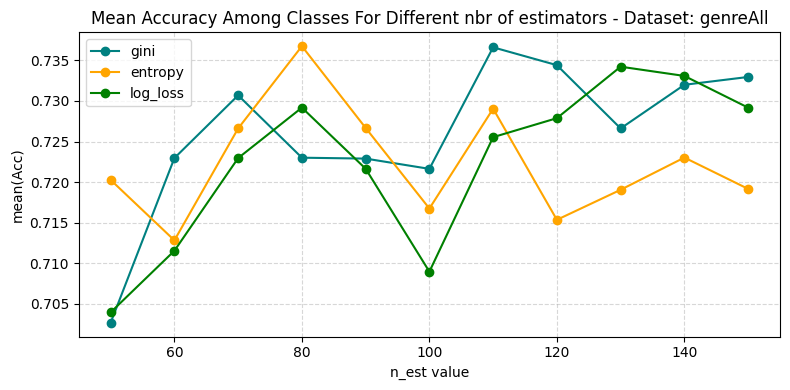

Dataset: genreAll
Best AccScore for gini criterion: 0.7366 ± 0.0333 (nbr_est = 110)
Best AccScore for entropy criterion: 0.7368 ±0.0236  (nbr_est = 80)
Best AccScore for log_loss criterion: 0.7342 ± 0.0514 (nbr_est = 130)
----------------------------------------------------------



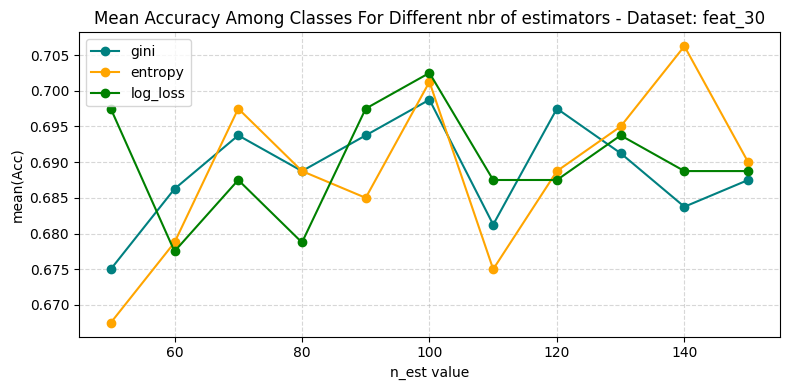

Dataset: feat_30
Best AccScore for gini criterion: 0.6987 ± 0.0435 (nbr_est = 100)
Best AccScore for entropy criterion: 0.7063 ±0.0458  (nbr_est = 140)
Best AccScore for log_loss criterion: 0.7025 ± 0.0588 (nbr_est = 100)
----------------------------------------------------------



In [ ]:
kf = KFold(n_splits=10, shuffle=True)

for dataset in data.keys():
    std_acc_gini = []
    avg_acc_gini = []
    std_acc_entropy = []
    avg_acc_entropy = []
    std_acc_log_loss = []
    avg_acc_log_loss = []


    X_train = data[dataset]['X_train']
    y_train = data[dataset]['y_train'].astype(int)
    X_test = data[dataset]['X_test']
    y_test = data[dataset]['y_test'].astype(int)
    for n_est in range(50,151,10):
    #gini:
        clf = RandomForestClassifier(n_estimators=n_est,criterion='gini')
        scores = cross_val_score(clf, X_train,y_train, cv=kf)
        avg_acc_gini.append(scores.mean())
        std_acc_gini.append(scores.std())
    #entropy:
        clf = RandomForestClassifier(n_estimators=n_est,criterion='entropy')
        scores = cross_val_score(clf, X_train,y_train, cv=kf)
        avg_acc_entropy.append(scores.mean())
        std_acc_entropy.append(scores.std())
    #log_loss:
        clf = RandomForestClassifier(n_estimators=n_est,criterion='log_loss')
        scores = cross_val_score(clf, X_train,y_train, cv=kf)
        avg_acc_log_loss.append(scores.mean())
        std_acc_log_loss.append(scores.std())


    plt.figure(figsize=(8, 4))
    plt.plot(range(50,151,10),avg_acc_gini,'o-', color='teal', label='gini')
    plt.plot(range(50,151,10),avg_acc_entropy,'o-', color='orange', label='entropy')
    plt.plot(range(50,151,10),avg_acc_log_loss,'o-', color='green', label='log_loss')

    plt.title(f"Mean Accuracy Among Classes For Different nbr of estimators - Dataset: {dataset}")
    plt.xlabel("n_est value")
    plt.ylabel("mean(Acc)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
    #data[dataset]['best_k'] = np.argmax(avg_acc_kn)+1 if max(avg_acc_kn)>max(avg_acc_kn_dist) else np.argmax(avg_acc_kn_dist)+1
    print("Dataset:", dataset)
    print(f"Best AccScore for gini criterion: {max(avg_acc_gini):.4f} ± {std_acc_gini[np.argmax(avg_acc_gini)]:.4f} (nbr_est = {np.argmax(avg_acc_gini)*10+50})")
    print(f"Best AccScore for entropy criterion: {max(avg_acc_entropy):.4f} ±{std_acc_entropy[np.argmax(avg_acc_entropy)]:.4f}  (nbr_est = {np.argmax(avg_acc_entropy)*10+50})")
    print(f"Best AccScore for log_loss criterion: {max(avg_acc_log_loss):.4f} ± {std_acc_log_loss[np.argmax(avg_acc_log_loss)]:.4f} (nbr_est = {np.argmax(avg_acc_log_loss)*10+50})")
    print('----------------------------------------------------------\n')

    data[dataset]['bestRandForest_criterion'] = 'gini' if np.mean(avg_acc_gini) > np.mean(avg_acc_entropy) and np.mean(avg_acc_gini) > np.mean(avg_acc_log_loss) else 'entropy' if np.mean(avg_acc_entropy) > np.mean(avg_acc_log_loss) else 'log_loss'
    data[dataset]['bestNbrEst'] = np.argmax(avg_acc_gini)*10+50 if np.mean(avg_acc_gini) > np.mean(avg_acc_entropy) and np.mean(avg_acc_gini) > np.mean(avg_acc_log_loss) else np.argmax(avg_acc_entropy)*10+50 if np.mean(avg_acc_entropy) > np.mean(avg_acc_log_loss) else np.argmax(avg_acc_log_loss)*10+50



## Multi Layer Perceptron

Finally, here we'll try with a Multi Layer perceptron (a fully-connected classic Artificial Neural Network). For it we'll explore different numbers of hidden layers.

In [ ]:
kf = KFold(n_splits=10, shuffle=True)

for dataset in data.keys():
    std_acc = []
    avg_acc = []

    X_train = data[dataset]['X_train']
    y_train = data[dataset]['y_train'].astype(int)
    X_test = data[dataset]['X_test']
    y_test = data[dataset]['y_test'].astype(int)

    for hidd_layers in range(50,351,50):
        clf = MLPClassifier(hidden_layer_sizes=hidd_layers, max_iter=1000,early_stopping=True)
        scores = cross_val_score(clf, X_train,y_train, cv=kf)
        avg_acc.append(scores.mean())
        std_acc.append(scores.std())


    plt.figure(figsize=(8, 4))
    plt.plot(range(50,351,50),avg_acc,'o-', color='teal')

    plt.title(f"Mean Accuracy Among Classes For Different nbr of Hidden Layers - Dataset: {dataset}")
    plt.xlabel("Nbr. of hidden layers")
    plt.ylabel("mean(Acc)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    data[dataset]['best_hid_layers'] = (np.argmax(avg_acc)+1)*50
    print("Dataset:", dataset)
    print(f"Best AccScore for MLP: {max(avg_acc):.4f} ± {std_acc[np.argmax(avg_acc)]:.4f} (nbr. hidden layers = {(np.argmax(avg_acc)+1)*50})")
    print('----------------------------------------------------------\n')

# Fitting all selected models

After selecting the most appropiate parameters for each case and dataset, we are ready to use them for prediction of the testing split. With this we'll see how well our models perform on unseen date and observe potential overfitting cases.

In [ ]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score,accuracy_score

scoring = {
    'accuracy': 'accuracy',
    'f1_macro': make_scorer(f1_score, average='macro'),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro')
}

for dataset_name in data.keys():
    data[dataset_name]['models'] = [
        LogisticRegression(random_state=0, max_iter=500),
        KNeighborsClassifier(n_neighbors=data[dataset]['best_k'], weights='distance'), #weight points by the inverse of their distance
        tree.DecisionTreeClassifier(criterion=data[dataset_name]['bestDecTreeCriterion']),
        RandomForestClassifier(random_state=0, criterion=data[dataset_name]['bestRandForest_criterion'], n_estimators=data[dataset_name]['bestNbrEst']),
        MLPClassifier(random_state=1, max_iter=1000,hidden_layer_sizes=data[dataset]['best_hid_layers'],early_stopping=True)
    ]


kf = KFold(n_splits=10, shuffle=True)
avg_acc = []
std_acc = []
models = ['LogisticRegression', 'k-NN', 'Decision Tree', 'Random Forest', 'MLP']

for dataset in data.keys():
    X_train = data[dataset]['X_train']
    y_train = data[dataset]['y_train'].astype(int)
    X_test = data[dataset]['X_test']
    y_test = data[dataset]['y_test'].astype(int)
    data[dataset]['train_scores'] = {
        'stdAcc': [], 'avgAcc': [], 'f1_macro': [], 'precision_macro': [], 'recall_macro': []
        }
    data[dataset]['test_scores'] = {
        'acc': [], 'f1_macro_test_scores': [], 'precision_macro_test_scores': [], 'recall_macro_test_scores': []
    }

    classifiers = data[dataset]['models']
    for clf, model in zip(classifiers, models):
        print(clf)
        scores = cross_val_score(clf, X_train,y_train, cv=kf, scoring='accuracy')
        extended_scores = cross_validate(clf, X_train, y_train, cv=10, scoring=scoring, return_train_score=False)
        data[dataset]['train_scores']['avgAcc'].append(scores.mean())
        data[dataset]['train_scores']['stdAcc'].append(scores.std())
        data[dataset]['train_scores']['f1_macro'].append(scores.mean())
        data[dataset]['train_scores']['precision_macro'].append(scores.std())
        data[dataset]['train_scores']['recall_macro'].append(scores.std())

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        data[dataset]['test_scores']['acc'].append( accuracy_score(y_test, y_pred))
        data[dataset]['test_scores']['f1_macro_test_scores'].append(f1_score(y_test, y_pred, average='macro'))
        data[dataset]['test_scores']['precision_macro_test_scores'].append(precision_score(y_test, y_pred, average='macro'))
        data[dataset]['test_scores']['recall_macro_test_scores'].append(recall_score(y_test, y_pred, average='macro'))



LogisticRegression(max_iter=500, random_state=0)
KNeighborsClassifier(n_neighbors=np.int64(5), weights='distance')
DecisionTreeClassifier()
RandomForestClassifier(criterion='entropy', n_estimators=np.int64(130),
                       random_state=0)
MLPClassifier(early_stopping=True, hidden_layer_sizes=np.int64(300),
              max_iter=1000, random_state=1)
LogisticRegression(max_iter=500, random_state=0)
KNeighborsClassifier(n_neighbors=np.int64(5), weights='distance')
DecisionTreeClassifier(criterion='entropy')
RandomForestClassifier(criterion='log_loss', n_estimators=np.int64(130),
                       random_state=0)
MLPClassifier(early_stopping=True, hidden_layer_sizes=np.int64(300),
              max_iter=1000, random_state=1)
LogisticRegression(max_iter=500, random_state=0)
KNeighborsClassifier(n_neighbors=np.int64(5), weights='distance')
DecisionTreeClassifier(criterion='log_loss')
RandomForestClassifier(criterion='log_loss', n_estimators=np.int64(150),
                 

In [ ]:
train_avg_acc = []
train_std_acc = []
train_f1_macro = []
train_precision_macro = []
train_recall_macro = []
test_acc = []
test_f1_macro = []
test_prec_macro = []
test_recall_macro = []

# First loop: collect all metrics into lists of arrays
for dataset in data.keys():
    train_avg_acc.append(data[dataset]['train_scores']['avgAcc'])
    train_std_acc.append(data[dataset]['train_scores']['stdAcc'])
    train_f1_macro.append(data[dataset]['train_scores']['f1_macro'])          # FIXED: use append
    train_precision_macro.append(data[dataset]['train_scores']['precision_macro'])  # FIXED
    train_recall_macro.append(data[dataset]['train_scores']['recall_macro'])        # FIXED
    test_acc.append(data[dataset]['test_scores']['acc'])
    test_f1_macro.append(data[dataset]['test_scores']['f1_macro_test_scores'])
    test_prec_macro.append(data[dataset]['test_scores']['precision_macro_test_scores'])
    test_recall_macro.append(data[dataset]['test_scores']['recall_macro_test_scores'])

# Convert to long-format DataFrame
plot_data = []
for dataset, avg_row, std_row, f1_train_row, prec_train_row, rec_train_row, test_acc_row, test_f1_row, test_prec_row, test_recall_row in zip(
        datasets, train_avg_acc, train_std_acc, train_f1_macro, train_precision_macro, train_recall_macro,
        test_acc, test_f1_macro, test_prec_macro, test_recall_macro):

    for i, model in enumerate(models):
        plot_data.append({
            'Dataset': dataset,
            'Model': model,
            'Train Avg Accuracy': avg_row[i],
            'Train Std': std_row[i],
            'Train F1 Macro': f1_train_row[i],
            'Train Precision Macro': prec_train_row[i],
            'Train Recall Macro': rec_train_row[i],
            'Test Accuracy': test_acc_row[i],
            'Test F1 Macro': test_f1_row[i],
            'Test Precision Macro': test_prec_row[i],
            'Test Recall Macro': test_recall_row[i]
        })

plot_df = pd.DataFrame(plot_data)
plot_df

,Dataset,Model,Train Avg Accuracy,Train Std,Train F1 Macro,Train Precision Macro,Train Recall Macro,Test Accuracy,Test F1 Macro,Test Precision Macro,Test Recall Macro
0,GenreAll,LogisticRegression,0.816203,0.037892,0.816203,0.037892,0.037892,0.748744,0.749979,0.777490,0.747794
1,GenreAll,k-NN,0.761741,0.065706,0.761741,0.065706,0.065706,0.713568,0.712906,0.734571,0.711421
2,GenreAll,Decision Tree,0.616946,0.061863,0.616946,0.061863,0.061863,0.527638,0.531768,0.551044,0.529360
3,GenreAll,Random Forest,0.759367,0.062576,0.759367,0.062576,0.062576,0.708543,0.711995,0.735964,0.717800
4,GenreAll,MLP,0.772073,0.062169,0.772073,0.062169,0.062169,0.723618,0.724542,0.735768,0.727321
5,features30,LogisticRegression,0.715000,0.032500,0.715000,0.032500,0.032500,0.730000,0.730194,0.734852,0.736592
6,features30,k-NN,0.686250,0.072122,0.686250,0.072122,0.072122,0.680000,0.682864,0.706479,0.688294
7,features30,Decision Tree,0.502500,0.047368,0.502500,0.047368,0.047368,0.560000,0.556097,0.554654,0.572385
8,features30,Random Forest,0.707500,0.035882,0.707500,0.035882,0.035882,0.735000,0.732083,0.737376,0.743159
9,features30,MLP,0.691250,0.054501,0.691250,0.054501,0.054501,0.690000,0.683655,0.697847,0.701146


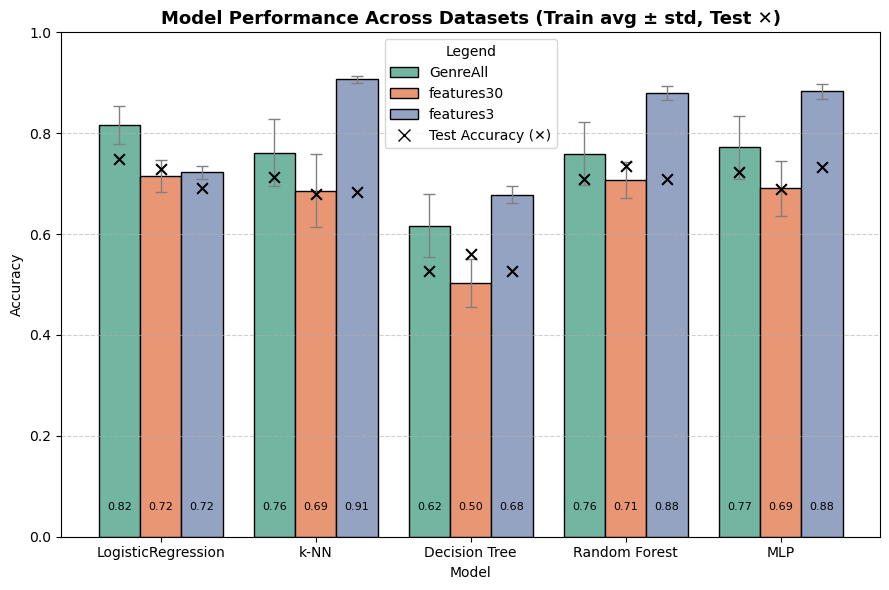

In [ ]:
plt.figure(figsize=(9, 6))
sns.barplot(data=plot_df, x='Model', y='Train Avg Accuracy', hue='Dataset',
            palette='Set2', edgecolor='k', errorbar=None)

# Add manual error bars + test markers + improved labels
bar_width = 0.8 / len(datasets)  # width of each subgroup bar
x_positions = np.arange(len(models))

for i, model in enumerate(models):
    for j, dataset in enumerate(datasets):
        subset = plot_df[(plot_df['Model'] == model) & (plot_df['Dataset'] == dataset)]
        mean = subset['Train Avg Accuracy'].values[0]
        std = subset['Train Std'].values[0]
        test = subset['Test Accuracy'].values[0]

        # Calculate the x position for this bar
        x_pos = i - 0.4 + bar_width/2 + j * bar_width

        # Error bar
        plt.errorbar(
            x=x_pos, y=mean, yerr=std,
            fmt='none', ecolor='grey', capsize=4, elinewidth=1
        )

        # Test score marker (✕)
        plt.scatter(
            x_pos, test, color='black', marker='x', s=60, zorder=3, label=None
        )

        # Accuracy label (slightly above the error bar to avoid overlap)
        plt.text(
            x_pos, 0.05,  # 0.015 offset avoids overlap
            f'{mean:.2f}', ha='center', va='bottom', fontsize=8
        )




# Custom legend handle for test values
test_marker = plt.Line2D([0], [0], color='black', marker='x', linestyle='None', markersize=8, label='Test Accuracy (✕)')

# Title and style
plt.title('Model Performance Across Datasets (Train avg ± std, Test ✕)', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Combine dataset legend + test marker
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles + [test_marker], labels + ['Test Accuracy (✕)'], title='Legend')

plt.tight_layout()
plt.show()

# Ensamble methods
Taking into account the results, we are gonna try to sum forces ensambling the three models that perform the best for the allGenre dataset.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier


dataset = 'genreAll'
chosen_clf = [0, 1, 3] #LogisticRegression, KNN, RandomForest

clf1 = data[dataset]['models'][chosen_clf[0]]
clf2 = data[dataset]['models'][chosen_clf[1]]
clf3 = data[dataset]['models'][chosen_clf[2]]

X_train = data[dataset]['X_train']
y_train = data[dataset]['y_train']
X_test = data[dataset]['X_test']
y_test = data[dataset]['y_test']

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
    voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression','kNN', 'Random Forest', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

eclf.fit(X_train, y_train)
y_pred = eclf.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f'\nEnsemble test accuracy: {accuracy:.2f}')

Accuracy: 0.81 (+/- 0.04) [Logistic Regression]
Accuracy: 0.74 (+/- 0.05) [kNN]
Accuracy: 0.76 (+/- 0.03) [Random Forest]
Accuracy: 0.82 (+/- 0.03) [Ensemble]
Ensemble test accuracy: 0.79


This case seem to improve results only partially, however, further analysis should be done in order to explore other combinations and potentially with different selected features

# Further feature selection
Finally, and regarding the observed overfitting specially for the feature3 dataset, let's try to reduce the dimmensinality and get better results

In [ ]:
feat_3 = pd.read_csv("/home/ibroto/Documents/UPF_SMC/ML/Lab1/Lab1/features_3_sec.csv")
scaler = preprocessing.StandardScaler()
for col in feat_3.columns[1:]:
    if isinstance(feat_3[col][0], str): print(f'  Textual column : {col} (values: {feat_3[col].unique()})')
    else:
        feat_3[col] = scaler.fit_transform(feat_3[[col]])

feat_label_dict = {'blues':0, 'classical':1, 'country':2, 'disco':3, 'hiphop':4, 'jazz':5, 'metal':6, 'pop':7, 'reggae':8,'rock':9}
feat_3['label'] = feat_3['label'].replace(feat_label_dict)


featSelector = SelectKBest(f_classif, k=60)
reduced_feat3 = featSelector.fit_transform(feat_3[feat_3.columns[2:-1]],feat_3[feat_3.columns[-1]])
reduced_feat3 = np.concatenate((feat_3[feat_3.columns[0]].values.reshape(-1, 1),reduced_feat3, feat_3[feat_3.columns[-1]].values.reshape(-1, 1)), axis=1)

